# **Lab 2: Brain Tumor MRI Feature Extraction**

- Reece Iriye: 48255107
- Eileen Garcia: 48241821
- Trevor Dohm: 48376059

## **0: Imports**

In [60]:
# Import Statements

# Data Manipulation
import numpy as np
import pandas as pd
import glob
import os

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Image Manipulation
from PIL import Image, ImageEnhance
import cv2

# Machine Learning
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import (
    DataLoader, 
    TensorDataset, 
    random_split,
    Dataset,
)

# Warnings
import sys
from typing import List, Dict, Union
import warnings
warnings.filterwarnings('ignore')

## **1: Business & Data Understanding**

## **2: Data Preparation**

In [70]:
# Load Train / Test Data
trainDataMRI: str = 'Dataset/Training/'
testDataMRI: str = 'Dataset/Testing/'
IMG_SIZE: int = 256

# Label Encoding
labels: List[str] = ['glioma', 'meningioma', 'notumor', 'pituitary']
label_indexes: Dict[str, int] = {
    label: i 
    for i, label in enumerate(labels)
}

# Empty Lists For Data
train_paths: List[np.ndarray] = []  # List of numpy arrays
train_labels: List[int] = []  # List of integers (encoded labels)
test_paths: List[np.ndarray] = []
test_labels: List[int] = []

# Load Training Data
for label in labels:
    for img_file in glob.glob(trainDataMRI + f'/{label}/*.jpg'):
        img: np.ndarray = cv2.imread(img_file, 0)  # This loads in grayscale. Remove ',0' for color.
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize if necessary
        img = img.astype(np.float32) / 255.0  # Normalize pixel values
        train_paths.append(img)
        train_labels.append(label_indexes[label])

# Load Testing Data
for label in labels:
    for img_file in glob.glob(testDataMRI + f'/{label}/*.jpg'):
        img: np.ndarray = cv2.imread(img_file, 0)  # This loads in grayscale. Remove ',0' for color.
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize if necessary
        img = img.astype(np.float32) / 255.0  # Normalize pixel values
        test_paths.append(img)
        test_labels.append(label_indexes[label])  

# Converting Lists To Numpy Arrays
trainPaths: np.ndarray = np.array(train_paths)
trainLabels: np.ndarray = np.array(train_labels)
testPaths: np.ndarray = np.array(test_paths)
testLabels: np.ndarray = np.array(test_labels)

# Resize Data (Linearize Images -> 1D Image Features Table, Row = Image)
trainPaths = trainPaths.reshape(trainPaths.shape[0], -1)
testPaths = testPaths.reshape(testPaths.shape[0], -1)

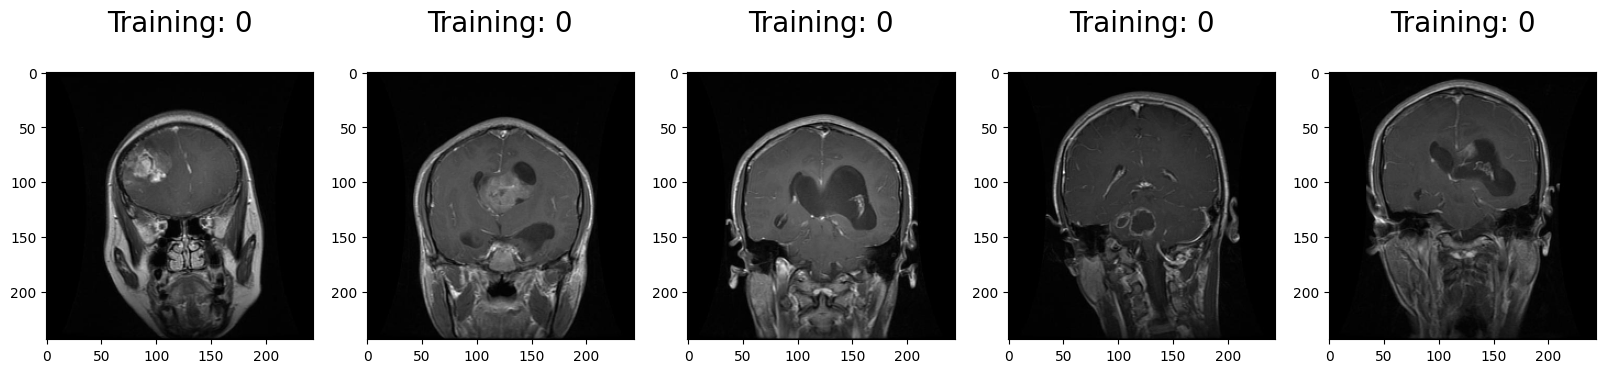

In [62]:
# Display Some Images From trainPaths
plt.figure(figsize=(20, 4))
for index, (image, label) in enumerate(zip(trainPaths[0:5], trainLabels[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (IMG_SIZE, IMG_SIZE)), cmap=plt.cm.gray)
    plt.title('Training: %i\n' % label, fontsize = 20)
plt.show()

## **3: Data Reduction**

### **3.1: Dimensionality Reduction with Principal Component Analysis**

### **3.2: Dimensionality with Randomized Principal Component Analysis**

### **3.3: Compare PCA and Randomized PCA**

### **3.4: Feature Extraction using ResNet**

For feature extraction, we decided to use a PyTorch implementation of the <a href="https://www.run.ai/guides/deep-learning-for-computer-vision/pytorch-resnet">Residual Network (ResNet)</a> architecture.  

In [10]:
# Instantiate the ResNet50 model
resnet50: models.ResNet = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\trevo/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:10<00:00, 9.39MB/s]


In [15]:
%%time
# 1. Prepare the ResNet50 model for transfer learning
# 
# This replaces the last fully connected layer (originally trained for 
# the 1000-class ImageNet dataset) with a new fully connected layer that matches the 
# number of classes in your MRI dataset. Since this layer is newly initialized, it 
# contains random weights and will be trained from scratch, while the other layers 
# contain pre-trained weights from ImageNet.
NUM_CLASSES: int = len(labels)
resnet50.fc: torch.nn.Module = (
    torch.nn.Linear(resnet50.fc.in_features, NUM_CLASSES)
)

# If CUDA (NVIDIA GPU acceleration) is available, use it. Otherwise, use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet50.to(device)  # Send the model to the selected device 

# 2. Prepare datasets for PyTorch
# Convert the loaded MRI images (numpy arrays) to PyTorch tensors
# Convert grayscale images to RGB format by repeating the single channel three times
train_tensors: Tensor = (
    torch.tensor(train_paths)
    .float()
    .view(-1, 1, IMG_SIZE, IMG_SIZE)
    .repeat(1, 3, 1, 1)  # GRAYSCALE IMAGE TO RGB FORMAT FOR torch.models 
)
test_tensors: Tensor = (
    torch.tensor(test_paths)
    .float()
    .view(-1, 1, IMG_SIZE, IMG_SIZE)
    .repeat(1, 3, 1, 1)  # GRAYSCALE IMAGE TO RGB FORMAT FOR torch.models
)

# Convert the image labels into tensor format for PyTorch
train_labels: Tensor = torch.tensor(train_labels).long()
test_labels: Tensor = torch.tensor(test_labels).long()

# Create PyTorch datasets using the image tensors and their corresponding labels
train_dataset: Dataset = TensorDataset(train_tensors, train_labels)
test_dataset: Dataset = TensorDataset(test_tensors, test_labels)

# Define data loaders to efficiently load image batches during training/testing
BATCH_SIZE: int = 32
train_loader: DataLoader = (
    DataLoader(
        train_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=True,  # Shuffling helps in better model generalization
    )
)
test_loader: DataLoader = (
    DataLoader(
        test_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=False, # No need to shuffle test data
    )
)

# 3. Train the model
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet50.parameters(), lr=0.001)

# Training loop (THIS LOOP WAS GENERATED BY CHATGPT)
NUM_EPOCHS: int = 10
for epoch in range(NUM_EPOCHS):
    resnet50.train()  # Set the model to training mode
    train_loss: float = 0.0  # Initialize training loss
    
    # For each batch of images and labels
    for images, labels in train_loader:
        images: Tensor = images.to(device)  # Send data to the device (GPU/CPU)
        labels: Tensor = labels.to(device)
        
        optimizer.zero_grad()  # Zero out any previous gradients
        outputs: Tensor = resnet50(images)  # Forward pass: Get model predictions
        loss: Tensor = criterion(outputs, labels)  # Compute the loss for this batch
        loss.backward()  # Backward pass: compute the gradient of the loss w.r.t. model parameters
        optimizer.step()  # Update the model's weights
        
        train_loss += loss.item()  # Accumulate the training loss

    # Print average training loss for this epoch        
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS} - Training loss: {train_loss/len(train_loader)}")

# 4. Evaluate the model
resnet50.eval()  # Set the model to evaluation mode
correct: int = 0  # Count of correct predictions
total: int = 0   # Total number of images processed

# We won't update the model, so we tell PyTorch not to compute gradients
with torch.no_grad():
    for images, labels in test_loader:
        images: Tensor = images.to(device)
        labels: Tensor = labels.to(device)
        outputs: Tensor = resnet50(images)
        _, predicted = torch.max(outputs.data, 1)  # Get the class with highest predicted probability
        total += labels.size(0)
        correct += (predicted == labels).sum().item()  # Count correct predictions

# Print the accuracy of the model on the test data
print(f"Accuracy of the model on test images: {100 * correct / total}%")

Epoch 1/10 - Training loss: 0.35524035465783915
Epoch 2/10 - Training loss: 0.24220305612550103
Epoch 3/10 - Training loss: 0.22305475699834984
Epoch 4/10 - Training loss: 0.1794577922110118
Epoch 5/10 - Training loss: 0.1266095000761431


RuntimeError: CUDA error: an illegal memory access was encountered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


### **3.5: ResNET Performance for Prediction Task**

## **4: Exceptional Work**

In [4]:
# Specify DinoV2 Local Path
REPO_PATH = "../../dinov2/"
sys.path.append(REPO_PATH)

In [5]:
from tqdm.notebook import tqdm
import math
import itertools
from functools import partial
import torch.nn.functional as functional
from dinov2.eval.depth.models import build_depther
import urllib
import mmcv
from mmcv.runner import load_checkpoint

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import random
import json

In [6]:
# Load Giant Model
dinov2_vitg14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vitg14")

# If CUDA (NVIDIA GPU acceleration) is available, use it. Otherwise, use CPU.
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
dinov2_vitg14.to(device)
dinov2_vitg14.eval()

Using cache found in C:\Users\trevo/.cache\torch\hub\facebookresearch_dinov2_main
A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitg14/dinov2_vitg14_pretrain.pth" to C:\Users\trevo/.cache\torch\hub\checkpoints\dinov2_vitg14_pretrain.pth
100%|██████████| 4.23G/4.23G [05:09<00:00, 14.7MB/s]


In [11]:
labels = {}

for folder in os.listdir('Dataset/Training/'):
    for file in os.listdir(os.path.join('Dataset/Training/', folder)):
        if file.endswith(".jpg"):
            full_name = os.path.join('Dataset/Training/', folder, file)
            labels[full_name] = folder

files = labels.keys()

In [105]:
import requests
from PIL import Image
from torchvision import transforms
transform = transforms.Compose([           
                                transforms.Resize(256),                    
                                transforms.CenterCrop(224),               
                                transforms.ToTensor(),                    
                                transforms.Normalize(                      
                                mean=[0.485, 0.456, 0.406],                
                                std=[0.229, 0.224, 0.225]              
                                )])


transform1 = transforms.Compose([           
                                transforms.Resize(512),
                                transforms.CenterCrop(518), #should be multiple of model patch_size                 
                                transforms.ToTensor(),                    
                                transforms.Normalize(mean=0.5, std=0.2)
                                ])

In [106]:
patch_size = dinov2_vitg14.patch_size # patchsize=14

#520//14
patch_h  = 520//patch_size
patch_w  = 520//patch_size

# feat_dim = 384 # vits14
# feat_dim = 768 # vitb14
# feat_dim = 1024 # vitl14
feat_dim = 1536 # vitg14

total_features  = []
with torch.no_grad():
    for label in labels:
        for img_file in glob.glob(train_data_mri + f'/{label}/*.jpg'):

            # Open Image File, Convert To RGB
            img = Image.open(img_file).convert('RGB')

            # Transform (Keeping Data Same), Force Data Onto Same Device
            img_t = transform1(img).to(device)

            # Forward Pass (Get Features)
            features_dict = dinov2_vitg14.forward_features(img_t.unsqueeze(0))
            features = features_dict['x_norm_patchtokens']
            total_features.append(features)

            break

total_features = torch.cat(total_features, dim = 0)
total_features.shape

torch.Size([4, 1369, 1536])

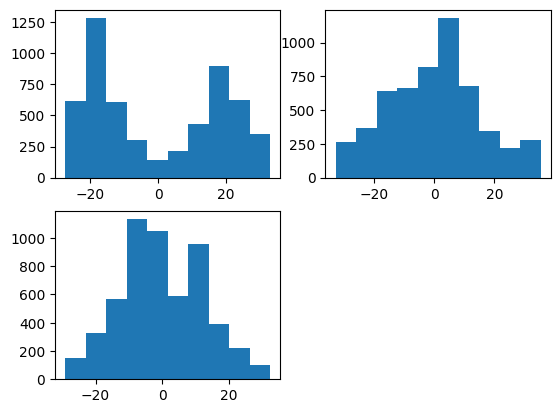

In [111]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# First PCA to Seperate Background
# sklearn expects 2d array for traning
total_features = total_features.reshape(4 * patch_h * patch_w, feat_dim) #4(*H*w, 1024)

pca = PCA(n_components=3)
# Copy the CUDA tensor to CPU memory
cpu_tensor = total_features.cpu()

# Convert the CPU tensor to a NumPy array
numpy_array = cpu_tensor.numpy()

pca.fit(numpy_array)
pca_features = pca.transform(numpy_array)

# visualize PCA components for finding a proper threshold
# 3 histograms for 3 components
plt.subplot(2, 2, 1)
plt.hist(pca_features[:, 0])
plt.subplot(2, 2, 2)
plt.hist(pca_features[:, 1])
plt.subplot(2, 2, 3)
plt.hist(pca_features[:, 2])
plt.show()
plt.close()

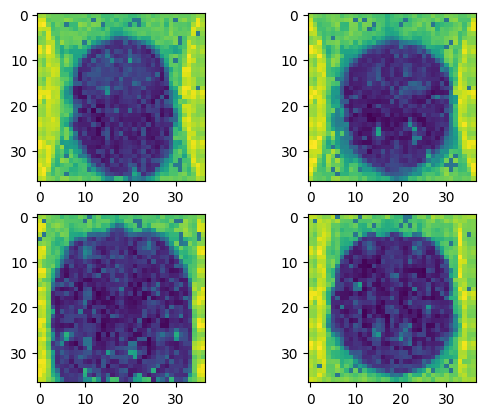

In [112]:
# min_max scale
pca_features[:, 0] = (pca_features[:, 0] - pca_features[:, 0].min()) / \
                     (pca_features[:, 0].max() - pca_features[:, 0].min())
#pca_features = sklearn.processing.minmax_scale(pca_features)

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features[i*patch_h*patch_w : (i+1)*patch_h*patch_w, 0].reshape(patch_h, patch_w))

plt.show()

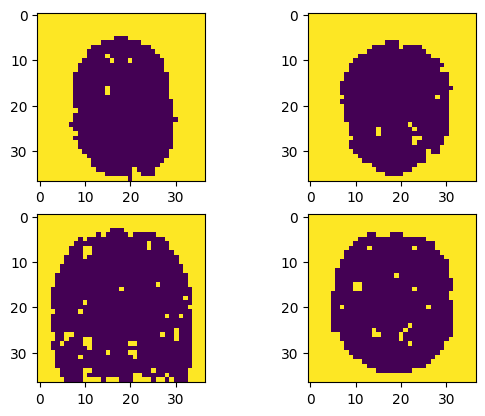

In [113]:
# segment/seperate the backgound and foreground using the first component
pca_features_bg = pca_features[:, 0] > 0.35 # from first histogram
pca_features_fg = ~pca_features_bg

# plot the pca_features_bg
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_bg[i * patch_h * patch_w: (i+1) * patch_h * patch_w].reshape(patch_h, patch_w))
plt.show()

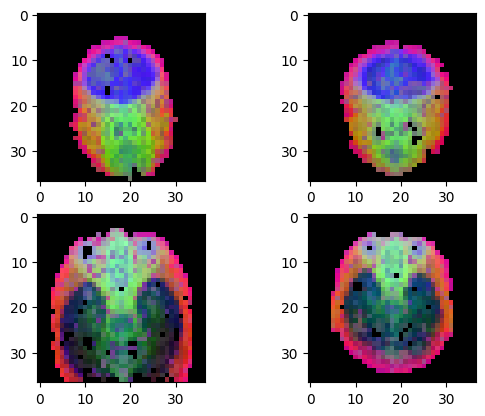

In [115]:
# 2nd PCA for only foreground patches
pca.fit(numpy_array[pca_features_fg]) 
pca_features_left = pca.transform(numpy_array[pca_features_fg])

for i in range(3):
    # min_max scaling
    pca_features_left[:, i] = (pca_features_left[:, i] - pca_features_left[:, i].min()) / (pca_features_left[:, i].max() - pca_features_left[:, i].min())

pca_features_rgb = pca_features.copy()
# for black background
pca_features_rgb[pca_features_bg] = 0
# new scaled foreground features
pca_features_rgb[pca_features_fg] = pca_features_left

# reshaping to numpy image format
pca_features_rgb = pca_features_rgb.reshape(4, patch_h, patch_w, 3)
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_rgb[i])

plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random